In [4]:
%matplotlib inline
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils import shuffle
from sklearn import metrics
from ggplot import *
from time import time
import operator
from tqdm import *

In [26]:
# loading datasets
THIS_COMPUTER = open("host_id.cfg").read().split()[0]

if THIS_COMPUTER == "vu":
    DATA_DIRS = [os.path.join("data", "test")]
    dataset_names = ["VUMC Data"]
elif THIS_COMPUTER == "nih":
    DATA_DIRS = [os.path.join("data", "test"),
                 os.path.join("data", "screening_umd"),
                 os.path.join("data", "screening_vcu")]
    dataset_names = ["NIH Data",
                     "Screening UMD",
                     "Screening VCU"]
sns.set(rc={'figure.figsize':(10, 7.5)})

In [28]:
metrics.roc_curve?

  0%|          | 0/3 [00:00<?, ?it/s]

['msl_half_2018-11-20_16:51:41_val_loss_-0.9882_vu_test', 'vu_ssl_2018-11-22_03:49:55_epoch_0106_val_dice_coef_0.9907_vu_test', 'msl_other_half_2018-11-22_03:06:22_val_loss_-0.9928_vu_test', 'nih_ssl_2018-11-22_03:50:11_epoch_0197_val_dice_coef_0.9898_vu_test', 'msl_full_2018-11-20_04:45:18_val_loss_-0.9867_vu_test']


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


[('MSL 1/2 A', <matplotlib.lines.Line2D object at 0x7fa7f38ab7f0>), ('SSL VUMC', <matplotlib.lines.Line2D object at 0x7fa7dace1d30>), ('MSL 1/2 B', <matplotlib.lines.Line2D object at 0x7fa7dae7d7b8>), ('SSL NIH', <matplotlib.lines.Line2D object at 0x7fa7dae7d668>), ('MSL Full', <matplotlib.lines.Line2D object at 0x7fa7dae7d128>)]
[('MSL 1/2 A', <matplotlib.lines.Line2D object at 0x7fa7f38ab7f0>), ('MSL 1/2 B', <matplotlib.lines.Line2D object at 0x7fa7dae7d7b8>), ('MSL Full', <matplotlib.lines.Line2D object at 0x7fa7dae7d128>), ('SSL NIH', <matplotlib.lines.Line2D object at 0x7fa7dae7d668>), ('SSL VUMC', <matplotlib.lines.Line2D object at 0x7fa7dace1d30>)]


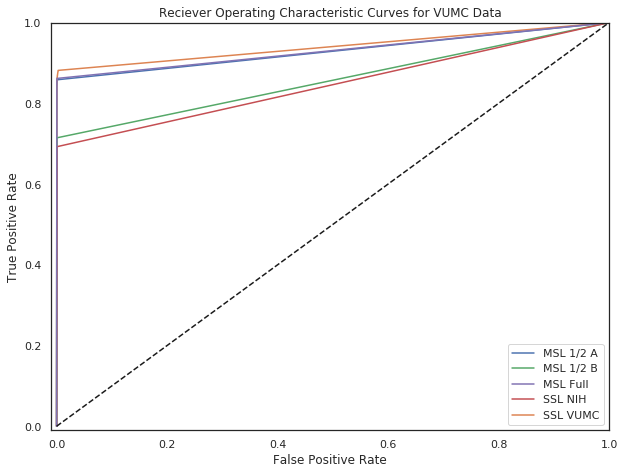

{'MSL 1/2 B': {'precision': 0.9279698508930034, 'thresholds': array([1.99928480e+00, 9.99284804e-01, 9.99224186e-01, ...,
       1.19769708e-38, 1.18074880e-38, 0.00000000e+00]), 'auc': 0.8571087642502754}, 'SSL NIH': {'precision': 0.8556682121567228, 'thresholds': array([1.99954695e+00, 9.99546945e-01, 9.99545753e-01, ...,
       1.18226332e-38, 1.18155987e-38, 0.00000000e+00]), 'auc': 0.8460167961186177}, 'MSL 1/2 A': {'precision': 0.938315582857766, 'thresholds': array([2.00000000e+00, 1.00000000e+00, 9.99999881e-01, ...,
       1.21328597e-38, 1.17589428e-38, 0.00000000e+00]), 'auc': 0.9290005816225425}, 'SSL VUMC': {'precision': 0.9389368854829381, 'thresholds': array([2.00000000e+00, 1.00000000e+00, 9.99999881e-01, ...,
       1.17666612e-38, 1.17582253e-38, 0.00000000e+00]), 'auc': 0.9404960907012065}, 'MSL Full': {'precision': 0.935856602544382, 'thresholds': array([2.00000000e+00, 1.00000000e+00, 9.99999881e-01, ...,
       1.24266489e-38, 1.23123660e-38, 0.00000000e+00]), 'au

In [45]:
for DATA_DIR, dataset_name in zip(DATA_DIRS, dataset_names):
    
    PREPROCESSING_DIR = os.path.join(DATA_DIR, "preprocessed")
    SEG_ROOT_DIR_BASE = os.path.join(DATA_DIR, "segmentations")
    MODELS = [x for x in os.listdir(SEG_ROOT_DIR_BASE) if "val" in x]
    print(MODELS)
    
    plt.title('Reciever Operating Characteristic Curves for ' + dataset_name)
    scores_dict = {}
    legend_items = []
    
    for i, model in enumerate(MODELS):
        
        if "msl_full" in model:
            model_name = "MSL Full"
        elif "msl_half" in model:
            model_name= "MSL 1/2 A"
        elif "msl_other" in model:
            model_name = "MSL 1/2 B"
        elif "nih_ssl" in model:
            model_name = "SSL NIH"
        elif "vu_ssl" in model:
            model_name = "SSL VUMC"

        SEG_ROOT_DIR = os.path.join(SEG_ROOT_DIR_BASE, model)


        pred_filenames = [os.path.join(SEG_ROOT_DIR, x) for x in os.listdir(SEG_ROOT_DIR) 
                      if not os.path.isdir(os.path.join(SEG_ROOT_DIR, x))]
        pred_filenames.sort()

        gt_filenames = [os.path.join(PREPROCESSING_DIR, x) for x in os.listdir(PREPROCESSING_DIR) 
                          if not os.path.isdir(os.path.join(PREPROCESSING_DIR, x))]
        gt_filenames = [x for x in gt_filenames if "mask" in x]
        gt_filenames.sort()
        
        pred_filenames = pred_filenames[:3]
        gt_filenames = gt_filenames[:3]
        
        x_gt_aggr = np.empty(shape=0)
        x_pred_aggr = np.empty(shape=0)
        x_thresh_aggr = np.empty(shape=0)

        # aggregate all volumes into one big volume
        for pred, gt in tqdm(zip(pred_filenames, gt_filenames), total=len(gt_filenames)):
            x = nib.load(pred).get_data()
            x_thresh = x.copy()
            x_thresh[np.where(x_thresh >= 0.5)] = 1
            x_thresh[np.where(x_thresh < 0.5)] = 0

            x_gt = nib.load(gt).get_data()

            x_gt_aggr = np.append(x_gt_aggr, x_gt.flatten())
            x_pred_aggr = np.append(x_pred_aggr, x.flatten())
            x_thresh_aggr = np.append(x_thresh_aggr, x_thresh.flatten())


        fpr, tpr, thresholds = metrics.roc_curve(x_gt_aggr, x_pred_aggr)
        auc = metrics.auc(fpr,tpr)
        precision = metrics.precision_score(x_gt_aggr, x_thresh_aggr)
        
        scores_dict[model_name] = {"auc": auc,
                                   "precision": precision,
                                   "thresholds": thresholds}
        
        label = model_name + " AUC = {:02f}".format(auc)
        line, = plt.plot(fpr, tpr, label=label)
        
        legend_items.append((model_name, line))


        
    # sort the legend
    legend_items.sort()
    plt.legend([x[1] for x in legend_items], [x[0] for x in legend_items])
    
    # plot the y=x line
    plt.plot([0,1],[0,1], 'k--')
    
    # set the range and domain of graph to display the x=0 values
    plt.xlim([-0.01,1])
    plt.ylim([-0.01,1])
    
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()

    print(dataset_name)
    print(scores_dict)
